# Clustering - Using Yelp's datasets 

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from pandas import Series, DataFrame

import scipy.sparse as sp_sparse
import scipy.spatial.distance as sp_dist
import scipy.cluster.hierarchy as hr
import scipy.sparse.linalg as linalg

import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn import preprocessing
import sklearn.cluster as sk_cluster
import sklearn.feature_extraction.text as sk_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder


import re
import random
import time
import seaborn as sns
import os
import json
import csv 
from csv import reader


%matplotlib inline

From the "yelp_academic_dataset_business.json" dataset keep businesses from the city of Toronto with the categories "Beauty & Spas", "Shopping" and "Bars", which they have at least 10 reviews.

For each business on the list get all the reviews for the business from the "yelp_academic_dataset_review.json" dataset and merge them in a great text for business.

In [2]:
business = []

with open("yelp_academic_dataset_business.json", encoding = "utf8", errors = "ignore") as f:
    for line in f:
        get_line = json.loads(line)
        business_id = get_line["business_id"]
        cat = get_line["categories"]
        # split categories from text to array
        if cat is not None:
            category = cat.split(", ")
        city = get_line["city"]
        count = get_line["review_count"]
        beauty = "Beauty & Spas"
        shopping = "Shopping"
        bars = "Bars"
        if city == "Toronto" and count>=10:                    
            if beauty in category:
                # if Beauty & Spas
                business.append((business_id,beauty))
            elif shopping in category:
                # if Shopping
                business.append((business_id,shopping))
            elif bars in category:
                # if Bars
                business.append((business_id,bars))
               

In [4]:
# get reviews where business in Toronto
only_bs = np.array(business)
check_for_business = list(only_bs[:,0])

reviews = []

with open("yelp_academic_dataset_review.json", encoding = "utf8", errors = "ignore") as f: 
    for line in f:
        get_line = json.loads(line)
        # get business id
        business_id = get_line["business_id"]
        # get text of business
        text = get_line["text"]

        if business_id in check_for_business:
            reviews.append((business_id,text))
                              

In [6]:
# for each business keep all the reviews given together in a text
reviews_per_business = []

for b in range(len(business)):

    # empty text for each business
    text_per_business=""
    for r in range(len(reviews)):
        if business[b][0]==reviews[r][0]:
            
            # remove punctuation
            text = re.sub("[^a-zA-Z]"," ",reviews[r][1])
            # remove tags
            text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
            # remove special characters and digits
            text = re.sub("(\\d|\\W)+"," ",text)
            # lower cases only
            text = text.lower()
            
            # get all texts 
            text_per_business += " " + text

    reviews_per_business.append((business[b][0],business[b][1],text_per_business))

In [8]:
# array to dataframe
df = pd.DataFrame(data=reviews_per_business,columns=["business_id","category","text"])
df

,business_id,category,text
0,cicPsia8Wj-DNRkmLbD_xg,Bars,consistently good as the keg tends to be high...
1,xVXyrTWbG8U3szze-aA7eg,Bars,i would give zero stars i came here with a gr...
2,e-tRKAC-q40SqQfAOwYa-A,Beauty & Spas,a blissful experience i highly recommended th...
3,C9keC4mWuXdl2mYFHZXudQ,Shopping,if you re a boy and you want to wear some hot...
4,PFS9kf3U-ZCvpqay3AaNnQ,Shopping,as a country girl i often find myself missing...
...,...,...,...
2986,Cesnh6fIsAUO8D4jfGhOIw,Shopping,good tacos in the downtown core are hard to c...
2987,lkq6i2x3vUsR7ZNrIFqoIw,Bars,this used to be my favourite place it was alw...
2988,wjqOdj0XJUDOOtU9LjRlWQ,Bars,very welcoming place great setup and super fr...
2989,AqpB2IoLkUupDCuH-hmVdg,Shopping,i can t beleive i am saying this but i left t...


In [9]:
# get text per business
corpus = df["text"].tolist()

In [10]:
# set 0,1,2 labels for each category
labelEnc = LabelEncoder()
categories = labelEnc.fit_transform(df["category"])
df["label"] = categories
df

,business_id,category,text,label
0,cicPsia8Wj-DNRkmLbD_xg,Bars,consistently good as the keg tends to be high...,0
1,xVXyrTWbG8U3szze-aA7eg,Bars,i would give zero stars i came here with a gr...,0
2,e-tRKAC-q40SqQfAOwYa-A,Beauty & Spas,a blissful experience i highly recommended th...,1
3,C9keC4mWuXdl2mYFHZXudQ,Shopping,if you re a boy and you want to wear some hot...,2
4,PFS9kf3U-ZCvpqay3AaNnQ,Shopping,as a country girl i often find myself missing...,2
...,...,...,...,...
2986,Cesnh6fIsAUO8D4jfGhOIw,Shopping,good tacos in the downtown core are hard to c...,2
2987,lkq6i2x3vUsR7ZNrIFqoIw,Bars,this used to be my favourite place it was alw...,0
2988,wjqOdj0XJUDOOtU9LjRlWQ,Bars,very welcoming place great setup and super fr...,0
2989,AqpB2IoLkUupDCuH-hmVdg,Shopping,i can t beleive i am saying this but i left t...,2


In [11]:
# get true labels
true_labels = df["label"].tolist()
true_labels

[0,
 0,
 1,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 1,


### TF-IDF of businesses

In [12]:
# The lower the value of a word, the less unique it is to any particular document.

# min_df = 50, ignore terms that appeared in less than 50 documents 
# max_df = 0.7, ignore terms that appear in 70% of the documents

vectorizer = sk_text.TfidfVectorizer(stop_words = 'english',min_df=50,max_df=0.70)
X = vectorizer.fit_transform(corpus)
print(X.toarray())  
print (vectorizer.get_feature_names())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['aaa', 'aback', 'abandoned', 'abilities', 'ability', 'able', 'abrupt', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absurd', 'abundance', 'abundant', 'abuse', 'abysmal', 'ac', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'accepting', 'accepts', 'access', 'accessibility', 'accessible', 'accessories', 'accident', 'accidentally', 'accommodate', 'accommodated', 'accommodating', 'accomodate', 'accomodating', 'accompanied', 'accompaniment', 'accompaniments', 'accompany', 'accompanying', 'according', 'accordingly', 'account', 'accounts', 'accurate', 'accurately', 'accused', 'accustomed', 'ace', 'acetone', 'achieve', 'achieved', 'acid', 'acidic', 'acidity', 'acknowledge', 'acknowledged', 'acknowledgement', 'acknowledging', 'acne', 'acoustics', 'acquired', 'acrylic', 'acrylics', 'act', 'acted

## Implement Clustering using K-Means and Agglomerative clustering with those categories

### K-Means

In [13]:
kmeans = sk_cluster.KMeans(n_clusters=3, init='k-means++', n_init=10)
kmeans.fit_predict(X)

centroids = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_
error = kmeans.inertia_

print ("The total error of the clustering is: ", error)
print ('\nCluster labels')
print(kmeans_labels)
print ('\n Cluster Centroids')
print (centroids)

The total error of the clustering is:  2407.913275506752

Cluster labels
[0 0 1 ... 0 1 0]

 Cluster Centroids
[[9.77775027e-04 4.21226766e-04 4.29845475e-04 ... 6.59178869e-04
  3.99342158e-04 2.21388308e-03]
 [3.13331655e-04 4.54208772e-04 2.46656822e-04 ... 1.79953764e-03
  4.49965704e-04 9.09288647e-05]
 [0.00000000e+00 3.77029557e-04 2.52558832e-04 ... 9.09072668e-04
  1.10878316e-04 0.00000000e+00]]


In [14]:
print("Top 20 terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(3):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print (' %s' % terms[ind])
    print

Top 20 terms per cluster:
Cluster 0:
 food
 bar
 menu
 beer
 drinks
 ordered
 restaurant
 chicken
 night
 patio
 fries
 pub
 server
 delicious
 table
 burger
 wings
 drink
 salad
 cheese
Cluster 1:
 store
 massage
 shop
 buy
 selection
 products
 stores
 items
 bike
 sales
 helpful
 appointment
 bought
 spa
 stuff
 help
 shopping
 room
 dress
 clothes
Cluster 2:
 hair
 nails
 salon
 nail
 cut
 shellac
 haircut
 manicure
 stylist
 appointment
 pedicure
 mani
 polish
 pedi
 colour
 job
 gel
 barber
 massage
 salons


[[1129    2   34]
 [   0  489    0]
 [ 129  335  873]]


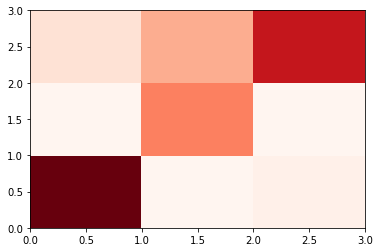

In [15]:
# get the mapping done and confusion matrix
def cluster_class_mapping(kmeans_labels,true_labels):
    C = metrics.confusion_matrix(kmeans_labels,true_labels)
    #for each row (cluster) find the best class in the confusion matrix
    mapping = list(np.argmax(C,axis=1)) 
    mapped_kmeans_labels = [mapping[l] for l in kmeans_labels]
    C_new = metrics.confusion_matrix(mapped_kmeans_labels,true_labels)
    return mapped_kmeans_labels,C_new

mapped_kmeans_labels,C = cluster_class_mapping(kmeans_labels,true_labels)
print(C)
plt.pcolormesh(C, cmap=plt.cm.Reds)

From the confusion matrix, we see that the cluster is not so good.
At first line, the first cluster has 1129 elements from class 1 and less from other classes. Second cluster has all elements from class 2 and the third cluster is shared, most elements are from class 3 but also has from class 2 a lot and class 1.
Now per columns, most elements of class 1 are in cluster 1, second class is shared to second and third cluster and most elements of third class are in cluster 3.

In [16]:
# keep in array the values
data_per_cluster = []
data_total = []
data_kmeans = []
data_kmeans_total = []

# precision metric per cluster
precision_per_cluster_1 = metrics.precision_score(true_labels,mapped_kmeans_labels, average=None)
print("Precision per cluster\n",precision_per_cluster_1)

# recall metric per cluster
recall_per_cluster_1 = metrics.recall_score(true_labels,mapped_kmeans_labels, average = None)
print("\nRecall per cluster\n",recall_per_cluster_1)

data_per_cluster.append(("K-means",precision_per_cluster_1[0],precision_per_cluster_1[1],precision_per_cluster_1[2],
                        recall_per_cluster_1[0],recall_per_cluster_1[1],recall_per_cluster_1[2]))

data_kmeans.append(("K-means, n_clusters=3",precision_per_cluster_1[0],precision_per_cluster_1[1],precision_per_cluster_1[2],
                    recall_per_cluster_1[0],recall_per_cluster_1[1],recall_per_cluster_1[2]))


# total precision
precision_total_1 = metrics.precision_score(true_labels,mapped_kmeans_labels, average='weighted')
print("\nWeighted Precision\n",precision_total_1)

# total recall
recall_total_1 = metrics.recall_score(true_labels,mapped_kmeans_labels, average = 'weighted')
print("\nWeighted Recall\n",recall_total_1)

data_total.append(("K-means",precision_total_1,recall_total_1))
data_kmeans_total.append(("K-means, n_clusters=3",precision_total_1,recall_total_1))

Precision per cluster
 [0.96909871 1.         0.65295438]

Recall per cluster
 [0.89745628 0.59200969 0.96251378]

Weighted Precision
 0.881763891275995

Weighted Recall
 0.8328318288197927


### Agglomerative clustering - Single-link

[[1258  826  904]
 [   0    0    0]
 [   0    0    3]]


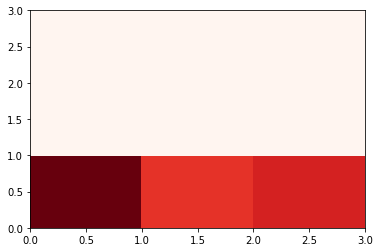

In [17]:
# linkage = single-link

agglo = sk_cluster.AgglomerativeClustering(linkage = 'single', n_clusters = 3)
agglo_labels = agglo.fit_predict(X.toarray())

mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
print(C_agglo)
plt.pcolormesh(C_agglo, cmap=plt.cm.Reds)

In [18]:
# precision metric per cluster
precision_per_cluster_2 = metrics.precision_score(true_labels,mapped_agglo_labels, average=None)
print("Precision per cluster\n",precision_per_cluster_2)

# recall metric per cluster
recall_per_cluster_2 = metrics.recall_score(true_labels,mapped_agglo_labels, average = None)
print("\nRecall per cluster\n",recall_per_cluster_2)

data_per_cluster.append(("Agglomerative - Single",precision_per_cluster_2[0],precision_per_cluster_2[1],precision_per_cluster_2[2],
                        recall_per_cluster_2[0],recall_per_cluster_2[1],recall_per_cluster_2[2]))

# total precision
precision_total_2 = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print("\nWeighted Precision\n",precision_total_2)

# total recall
recall_total_2 = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print("\nWeighted Recall\n",recall_total_2)

data_total.append(("Agglomerative - Single",precision_total_2,recall_total_2))

Precision per cluster
 [0.4210174 0.        1.       ]

Recall per cluster
 [1.         0.         0.00330761]

Weighted Precision
 0.4803209270828998

Weighted Recall
 0.4215981277164828


/home/ze/anaconda3/envs/dataEnv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Agglomerative clustering - Complete-link

[[1236    3   94]
 [   6  737   18]
 [  16   86  795]]


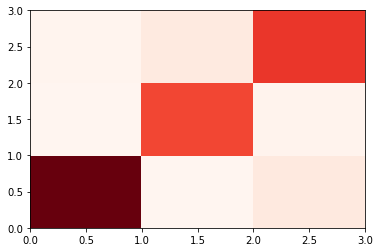

In [19]:
# linkage = complete-link

agglo = sk_cluster.AgglomerativeClustering(linkage = 'complete', n_clusters = 3)
agglo_labels = agglo.fit_predict(X.toarray())

mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
print(C_agglo)
plt.pcolormesh(C_agglo, cmap=plt.cm.Reds)

In [20]:
# precision metric per cluster
precision_per_cluster_3 = metrics.precision_score(true_labels,mapped_agglo_labels, average=None)
print("Precision per cluster\n",precision_per_cluster_3)

# recall metric per cluster
recall_per_cluster_3 = metrics.recall_score(true_labels,mapped_agglo_labels, average = None)
print("\nRecall per cluster\n",recall_per_cluster_3)

data_per_cluster.append(("Agglomerative - Complete",precision_per_cluster_3[0],precision_per_cluster_3[1],precision_per_cluster_3[2],
                        recall_per_cluster_3[0],recall_per_cluster_3[1],recall_per_cluster_3[2]))

# total precision
precision_total_3 = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print("\nWeighted Precision\n",precision_total_3)

# total recall
recall_total_3 = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print("\nWeighted Recall\n",recall_total_3)

data_total.append(("Agglomerative - Complete",precision_total_3,recall_total_3))

Precision per cluster
 [0.92723181 0.96846255 0.88628763]

Recall per cluster
 [0.98251192 0.89225182 0.87651599]

Weighted Precision
 0.9262021251624218

Weighted Recall
 0.9254429956536275


### Agglomerative clustering - Average

[[1258   64  905]
 [   0  762    1]
 [   0    0    1]]


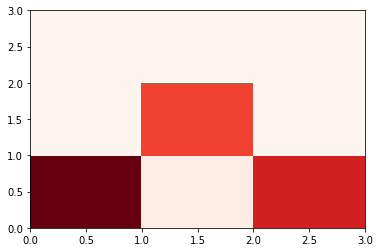

In [21]:
# linkage = average

agglo = sk_cluster.AgglomerativeClustering(linkage = 'average', n_clusters = 3)
agglo_labels = agglo.fit_predict(X.toarray())

mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
print(C_agglo)
plt.pcolormesh(C_agglo, cmap=plt.cm.Reds)

In [22]:
# precision metric per cluster
precision_per_cluster_4 = metrics.precision_score(true_labels,mapped_agglo_labels, average=None)
print("Precision per cluster\n",precision_per_cluster_4)

# recall metric per cluster
recall_per_cluster_4 = metrics.recall_score(true_labels,mapped_agglo_labels, average = None)
print("\nRecall per cluster\n",recall_per_cluster_4)

data_per_cluster.append(("Agglomerative - Average",precision_per_cluster_4[0],precision_per_cluster_4[1],precision_per_cluster_4[2],
                        recall_per_cluster_4[0],recall_per_cluster_4[1],recall_per_cluster_4[2]))

# total precision
precision_total_4 = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print("\nWeighted Precision\n",precision_total_4)

# total recall
recall_total_4 = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print("\nWeighted Recall\n",recall_total_4)

data_total.append(("Agglomerative - Average",precision_total_4,recall_total_4))

Precision per cluster
 [0.5648855  0.99868938 1.        ]

Recall per cluster
 [1.         0.92251816 0.00110254]

Weighted Precision
 0.8166310215282961

Weighted Recall
 0.6756937479103978


### Agglomerative clustering - Ward

[[1245    7  103]
 [   0  211    0]
 [  13  608  804]]


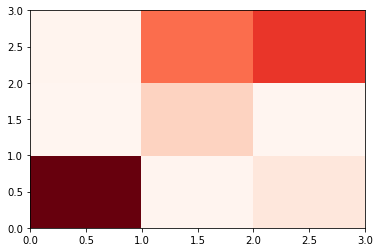

In [23]:
# linkage = ward

agglo = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 3)
agglo_labels = agglo.fit_predict(X.toarray())

mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
print(C_agglo)
plt.pcolormesh(C_agglo, cmap=plt.cm.Reds)

In [24]:
# precision metric per cluster
precision_per_cluster_5 = metrics.precision_score(true_labels,mapped_agglo_labels, average=None)
print("Precision per cluster\n",precision_per_cluster_5)

# recall metric per cluster
recall_per_cluster_5 = metrics.recall_score(true_labels,mapped_agglo_labels, average = None)
print("\nRecall per cluster\n",recall_per_cluster_5)

data_per_cluster.append(("Agglomerative - Ward",precision_per_cluster_5[0],precision_per_cluster_5[1],precision_per_cluster_5[2],
                        recall_per_cluster_5[0],recall_per_cluster_5[1],recall_per_cluster_5[2]))

# total precision
precision_total_5 = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print("\nWeighted Precision\n",precision_total_5)

# total recall
recall_total_5 = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print("\nWeighted Recall\n",recall_total_5)

data_total.append(("Agglomerative - Ward",precision_total_5,recall_total_5))

Precision per cluster
 [0.91881919 1.         0.56421053]

Recall per cluster
 [0.98966614 0.25544794 0.88643881]

Weighted Precision
 0.8337056122078932

Weighted Recall
 0.7556001337345369


In [25]:
df_per_cluster = pd.DataFrame(data=data_per_cluster,columns=["clustering","(precision_per_cluster,","precision_per_cluster,","precision_per_cluster)",
                            "(recall_per_cluster,","recall_per_cluster,","recall_per_cluster)"])
df_per_cluster

,clustering,"(precision_per_cluster,","precision_per_cluster,",precision_per_cluster),"(recall_per_cluster,","recall_per_cluster,",recall_per_cluster)
0,K-means,0.969099,1.000000,0.652954,0.897456,0.592010,0.962514
1,Agglomerative - Single,0.421017,0.000000,1.000000,1.000000,0.000000,0.003308
2,Agglomerative - Complete,0.927232,0.968463,0.886288,0.982512,0.892252,0.876516
3,Agglomerative - Average,0.564885,0.998689,1.000000,1.000000,0.922518,0.001103
4,Agglomerative - Ward,0.918819,1.000000,0.564211,0.989666,0.255448,0.886439


- K-Means:

    - Precision per cluster:
    The first two clusters are good enough (best value is 1 and the worst value is 0) and the third is not good - the matching is wrong.

    - Recall per cluster:
    First and third clusters are good, while second isn't. 


- Agglomerative clustering - Single:

    - Precision per cluster:
    Uses the minimum of the distances between all observations of the two sets, only the third cluster seems to be good, with a score of 1 (best value). First cluster value is low while second cluster has value zero(worst value), the matching is completly wrong. 
    
    - Recall per cluster:
    Only the first cluster has high values and the other clusters are zero. Very bad.
    
    
    
- Agglomerative clustering - Complete:

    - Precision per cluster:
    Uses the maximum distances between all observations of the two sets, all the three clusters have high values, so most elements of each cluster are matched correctly.
    - Recall per cluster:
    Same as precision per cluster, all clusters have high values, meaning the matching is excellent.
    Best clustering results for confusion matrix, precision and recall so far - about the matching.
    
    
- Agglomerative clustering - Average:

    - Precision per cluster:
    Uses the average of the distances of each observation of the two sets, second and third clusters are ~1, first cluster has middle value.
    - Recall per cluster:
    First and second clusters are good, while third has the worst value zero.
    

- Agglomerative clustering - Ward:

    - Precision per cluster:
    Minimizes the variance of the clusters being merged, first and second clusters are good while third not so good.
    - Recall per cluster:
    While at precision the first and second clusters are good, now at recall per cluster, first and third clusters matching are ok and second isn't.
    
    
Based on above results the best clustering with high values is Agglomerative clustering - Complete.

In [26]:
df_total = pd.DataFrame(data=data_total,columns=["clustering","weighted_precision","weighted_recall"])
df_total

,clustering,weighted_precision,weighted_recall
0,K-means,0.881764,0.832832
1,Agglomerative - Single,0.480321,0.421598
2,Agglomerative - Complete,0.926202,0.925443
3,Agglomerative - Average,0.816631,0.675694
4,Agglomerative - Ward,0.833706,0.755600


Now we see that the Complete Agglomerative Clustering has the high values in term of precision and recall(best way to do the clustering).

## It is possible that the texts are not clustered in a way that agrees with the categories, so using K-Means and Silhouette plot to find out.

Text(0, 0.5, 'Error')

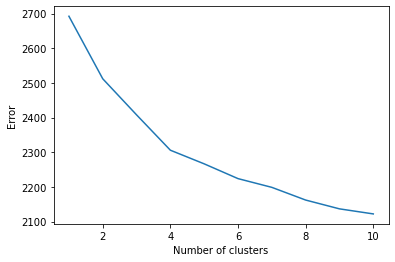

In [27]:
error = np.zeros(11)
sh_score = np.zeros(11)
for k in range(1,11):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X)
    error[k] = kmeans.inertia_
    if k>1: sh_score[k]= metrics.silhouette_score(X, kmeans.labels_)

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

Text(0, 0.5, 'silhouette score')

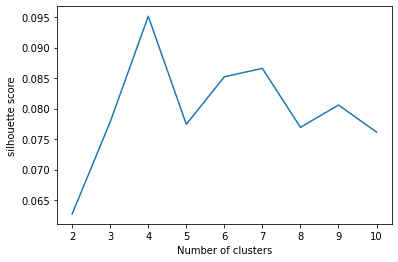

In [28]:
plt.plot(range(2,len(sh_score)),sh_score[2:])
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')

### K-Means, n_clusters=7
Based on results of silhouette score, we choose n_clusters = 7

In [40]:
kmeans = sk_cluster.KMeans(n_clusters=7, init='k-means++', n_init=10)
kmeans.fit_predict(X)

centroids = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_

print ('\nCluster labels')
print(kmeans_labels)
print ('\n Cluster Centroids')
print (centroids)


Cluster labels
[4 0 6 ... 5 2 0]

 Cluster Centroids
[[9.76364174e-04 3.19703823e-04 4.97896940e-04 ... 7.74212051e-04
  2.49215989e-04 5.23292844e-04]
 [0.00000000e+00 3.95468369e-04 3.05014954e-04 ... 1.02653982e-03
  1.68211478e-05 0.00000000e+00]
 [3.49658917e-04 4.97499589e-04 2.81263009e-04 ... 1.21927350e-03
  5.14253619e-04 1.12040412e-04]
 ...
 [1.33880528e-03 5.16638159e-04 3.86235065e-04 ... 4.51527513e-04
  4.23733992e-04 4.12729353e-03]
 [1.84760467e-04 4.17878417e-04 3.38591015e-04 ... 2.75238292e-03
  5.20212116e-04 3.36587088e-04]
 [7.98576868e-05 2.39142007e-04 8.83856296e-05 ... 1.98699844e-03
  2.22585359e-04 0.00000000e+00]]


In [41]:
print("Top 20 terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(3):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print (' %s' % terms[ind])
    print

Top 20 terms per cluster:
Cluster 0:
 food
 beer
 pub
 bar
 wings
 fries
 burger
 patio
 menu
 drinks
 ordered
 chicken
 server
 night
 beers
 drink
 table
 cheese
 nachos
 waitress
Cluster 1:
 hair
 cut
 salon
 haircut
 stylist
 barber
 appointment
 colour
 stylists
 cuts
 job
 barbers
 trim
 blow
 style
 highlights
 haircuts
 wash
 salons
 cutting
Cluster 2:
 store
 shop
 buy
 stores
 bike
 selection
 items
 sales
 products
 shopping
 helpful
 stuff
 bought
 clothes
 dress
 shoes
 sale
 help
 clothing
 books


[[1252    7   67]
 [   0  713    0]
 [   6  106  840]]


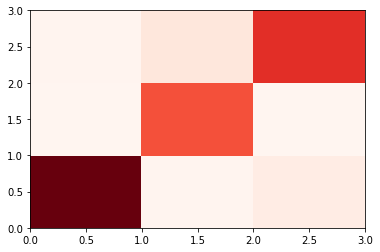

In [42]:
mapped_kmeans_labels_c,C = cluster_class_mapping(kmeans_labels,true_labels)
print(C)
plt.pcolormesh(C, cmap=plt.cm.Reds)

From the confusion matrix, it is clear to say that the cluster is good. At first line, the first cluster has elements from class 1 and less from other classes. Second cluster has almost all elements from class 2 and same goes for third cluster.Per columns, most elements of class 1 are in cluster 1, second class in cluster 2 and third class to cluster 3.
We can say it is a good clustering.

In [43]:
# precision metric per cluster
precision_per_cluster_c = metrics.precision_score(true_labels,mapped_kmeans_labels_c, average=None)
print("Precision per cluster\n",precision_per_cluster_c)

# recall metric per cluster
recall_per_cluster_c = metrics.recall_score(true_labels,mapped_kmeans_labels_c, average = None)
print("\nRecall per cluster\n",recall_per_cluster_c)

data_kmeans.append(("K-means, n_clusters=7",precision_per_cluster_c[0],precision_per_cluster_c[1],precision_per_cluster_c[2],
                    recall_per_cluster_c[0],recall_per_cluster_c[1],recall_per_cluster_c[2]))

# total precision
precision_total_c = metrics.precision_score(true_labels,mapped_kmeans_labels_c, average='weighted')
print("\nWeighted Precision\n",precision_total_c)

# total recall
recall_total_c = metrics.recall_score(true_labels,mapped_kmeans_labels_c, average = 'weighted')
print("\nWeighted Recall\n",recall_total_c)

data_kmeans_total.append(("K-means, n_clusters=7",precision_total_c,recall_total_c))

Precision per cluster
 [0.94419306 1.         0.88235294]

Recall per cluster
 [0.99523052 0.86319613 0.9261301 ]

Weighted Precision
 0.9408522198067304

Weighted Recall
 0.9378134403209629


In [44]:
df_per_cluster = pd.DataFrame(data=data_kmeans,columns=["clustering","(precision_per_cluster,","precision_per_cluster,","precision_per_cluster)",
                            "(recall_per_cluster,","recall_per_cluster,","recall_per_cluster)"])
df_per_cluster

,clustering,"(precision_per_cluster,","precision_per_cluster,",precision_per_cluster),"(recall_per_cluster,","recall_per_cluster,",recall_per_cluster)
0,"K-means, n_clusters=3",0.969099,1.0,0.652954,0.897456,0.592010,0.962514
1,"K-means, n_clusters=7",0.944193,1.0,0.882353,0.995231,0.863196,0.926130


K-Means with number of clusters = 7, compared to number of clusters = 3, results are way better, each cluster seems to be matched with correct class it belongs to.

In [45]:
df_total = pd.DataFrame(data=data_kmeans_total,columns=["clustering","weighted_precision","weighted_recall"])
df_total

,clustering,weighted_precision,weighted_recall
0,"K-means, n_clusters=3",0.881764,0.832832
1,"K-means, n_clusters=7",0.940852,0.937813


As number of clusters = 7, the weighted precision and recall are getting high values than before